# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:24<00:00, 2.42KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

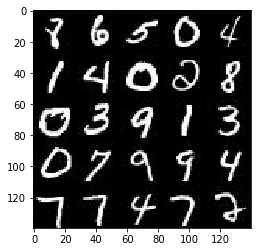

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

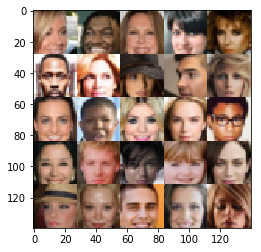

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/dfeng/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        fullyCon = tf.layers.dense(z, 7*7*256)
        fullyCon = tf.reshape(fullyCon, (-1, 7, 7, 256))
        fullyCon = tf.layers.batch_normalization(fullyCon, training=is_train)
        fullyCon = tf.maximum(alpha*fullyCon, fullyCon)
        
        conv1 = tf.layers.conv2d_transpose(fullyCon, 56, 5, 2, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 1, 'SAME')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 1.8820... Generator Loss: 1.8105
Epoch 1/2... Discriminator Loss: 1.6376... Generator Loss: 1.4423
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 2.1491... Generator Loss: 1.3933
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.8584... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 1.7188... Generator Loss: 1.2310
Epoch 1/2... Discriminator Loss: 1.6544... Generator Loss: 1.5739
Epoch 1/2... Discriminator Loss: 1.6504... Generator Loss: 1.1435


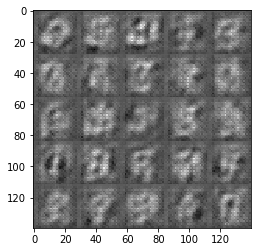

Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 1.0931
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.5419... Generator Loss: 1.3765
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 1.2524
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 1.1977
Epoch 1/2... Discriminator Loss: 1.7808... Generator Loss: 0.2509
Epoch 1/2... Discriminator Loss: 1.9159... Generator Loss: 0.2352


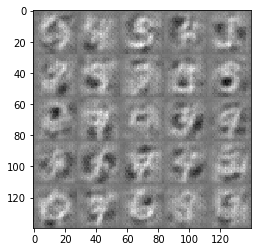

Epoch 1/2... Discriminator Loss: 2.1124... Generator Loss: 0.1639
Epoch 1/2... Discriminator Loss: 1.6060... Generator Loss: 0.3590
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.3615
Epoch 1/2... Discriminator Loss: 2.1456... Generator Loss: 0.1524
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.4276
Epoch 1/2... Discriminator Loss: 1.4555... Generator Loss: 1.1586
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 1.4022
Epoch 1/2... Discriminator Loss: 1.7123... Generator Loss: 0.2558


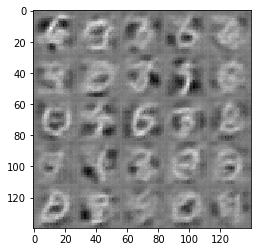

Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 1.1605
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 1.0503
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.9550
Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 1.3697
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.0664
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 1.2391


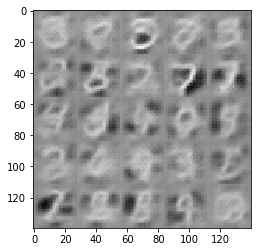

Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.4220
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 1.8799
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 1.0950
Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 1.6681
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.9861
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.9364


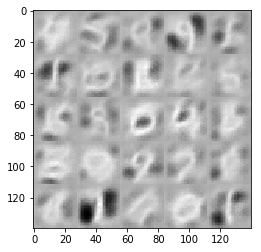

Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 1.4544
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 1.1402
Epoch 1/2... Discriminator Loss: 1.7147... Generator Loss: 0.2618
Epoch 1/2... Discriminator Loss: 1.8372... Generator Loss: 0.2297
Epoch 1/2... Discriminator Loss: 1.6459... Generator Loss: 0.3048
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.6084
Epoch 1/2... Discriminator Loss: 1.9583... Generator Loss: 0.1996
Epoch 1/2... Discriminator Loss: 1.7732... Generator Loss: 0.2702
Epoch 1/2... Discriminator Loss: 1.9182... Generator Loss: 0.2189
Epoch 1/2... Discriminator Loss: 2.3761... Generator Loss: 0.1194


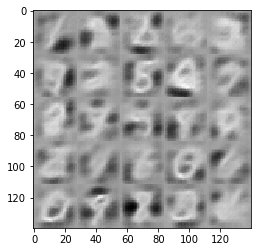

Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.4745... Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 2.0587... Generator Loss: 0.1644
Epoch 1/2... Discriminator Loss: 1.7805... Generator Loss: 0.2157
Epoch 1/2... Discriminator Loss: 1.6750... Generator Loss: 0.2646
Epoch 1/2... Discriminator Loss: 2.0345... Generator Loss: 0.1759
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.4320
Epoch 1/2... Discriminator Loss: 1.6366... Generator Loss: 0.2665
Epoch 1/2... Discriminator Loss: 1.5930... Generator Loss: 0.2810
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.5086


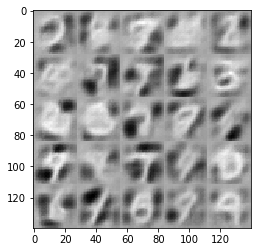

Epoch 1/2... Discriminator Loss: 1.5205... Generator Loss: 0.3552
Epoch 1/2... Discriminator Loss: 1.7688... Generator Loss: 0.2354
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 2.0520... Generator Loss: 0.1753
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 0.8985
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.2978
Epoch 1/2... Discriminator Loss: 1.6940... Generator Loss: 0.2674
Epoch 1/2... Discriminator Loss: 1.9375... Generator Loss: 0.2387
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 1.5487


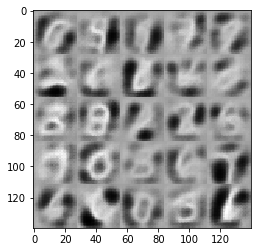

Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 1.2347
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 1.1604
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.2551
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.6501... Generator Loss: 0.3026
Epoch 1/2... Discriminator Loss: 1.9873... Generator Loss: 0.1853
Epoch 1/2... Discriminator Loss: 1.8175... Generator Loss: 0.2628
Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 0.3161


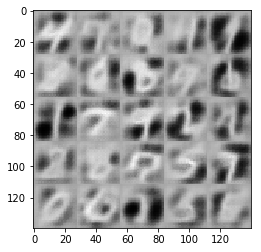

Epoch 1/2... Discriminator Loss: 1.6399... Generator Loss: 0.2674
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 1.1909
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.9498
Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 2.0487... Generator Loss: 0.1806
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.5451... Generator Loss: 0.3271
Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 1.1983


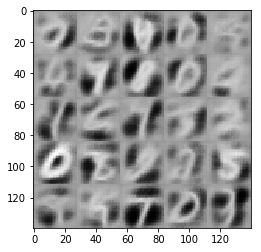

Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 1.0359
Epoch 1/2... Discriminator Loss: 2.4285... Generator Loss: 3.0594
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.8284
Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.3580
Epoch 1/2... Discriminator Loss: 1.6367... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 1.4157
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 1.5799
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 0.5745


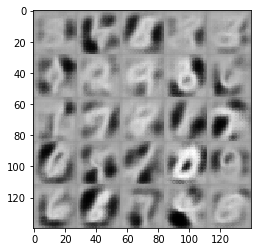

Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.5521
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.7796... Generator Loss: 2.0632
Epoch 1/2... Discriminator Loss: 0.8118... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.9554... Generator Loss: 0.2361
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 0.7539
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 1.9222
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 1.2663
Epoch 1/2... Discriminator Loss: 2.0155... Generator Loss: 0.2328


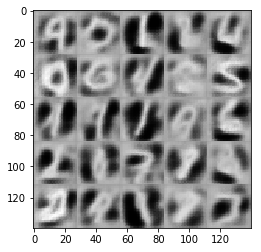

Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 2.0050... Generator Loss: 2.1223
Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 1.0084
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 0.9089
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 1.6740
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.7876
Epoch 1/2... Discriminator Loss: 1.6563... Generator Loss: 0.2958
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 2.2276
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 1.3697
Epoch 1/2... Discriminator Loss: 0.9889... Generator Loss: 1.3582


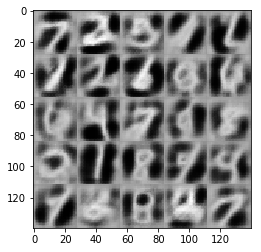

Epoch 1/2... Discriminator Loss: 1.6294... Generator Loss: 0.2909
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.4763
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 1.9781... Generator Loss: 0.2335
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.7587
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.3474
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.3818
Epoch 1/2... Discriminator Loss: 1.8040... Generator Loss: 0.2269


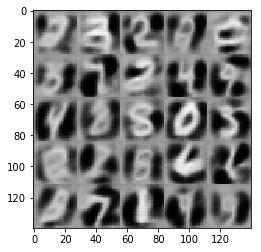

Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.7417
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 0.5544
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 0.5643
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.1586
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.6968... Generator Loss: 0.2749
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 0.3555
Epoch 1/2... Discriminator Loss: 1.7872... Generator Loss: 0.2572
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.7636


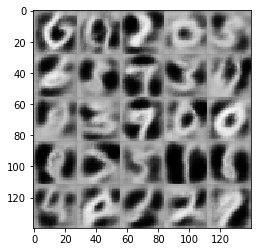

Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 0.9720
Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.6947... Generator Loss: 0.2807
Epoch 1/2... Discriminator Loss: 2.1537... Generator Loss: 0.1809
Epoch 1/2... Discriminator Loss: 1.4809... Generator Loss: 0.3899
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.6177... Generator Loss: 0.3612
Epoch 1/2... Discriminator Loss: 1.8721... Generator Loss: 0.2292
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.5449


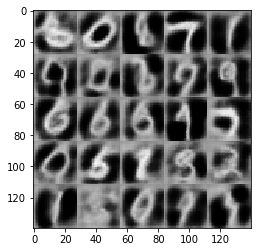

Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 1.8537... Generator Loss: 0.2850
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 1.3974
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 1.5489
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 1.6970... Generator Loss: 2.0586
Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 0.9132
Epoch 1/2... Discriminator Loss: 0.7860... Generator Loss: 1.2991
Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 1.9692
Epoch 1/2... Discriminator Loss: 1.5860... Generator Loss: 0.3067


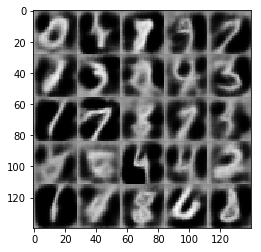

Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.4202
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.4939
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 0.7488
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 1.7376
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.7096
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 0.8920... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 1.0762


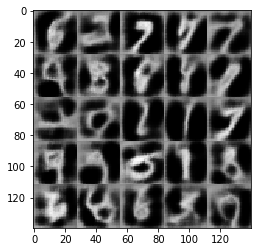

Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.3823
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.5055
Epoch 1/2... Discriminator Loss: 0.8098... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.3913
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.3253
Epoch 1/2... Discriminator Loss: 1.5936... Generator Loss: 0.3040
Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.1875
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.3220
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.5904
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.5988


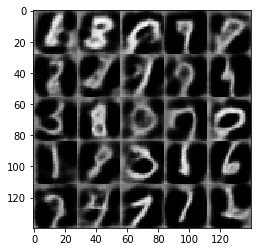

Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 1.5419... Generator Loss: 0.3820
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 2.3955
Epoch 2/2... Discriminator Loss: 0.9000... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 0.9406
Epoch 2/2... Discriminator Loss: 0.3912... Generator Loss: 1.7864
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.7497


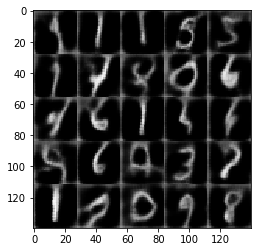

Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 0.7114
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 3.0352
Epoch 2/2... Discriminator Loss: 1.6811... Generator Loss: 0.3250
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 1.9469... Generator Loss: 0.2114
Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.5097... Generator Loss: 0.4817
Epoch 2/2... Discriminator Loss: 1.6502... Generator Loss: 0.2949
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 0.9791... Generator Loss: 1.6783


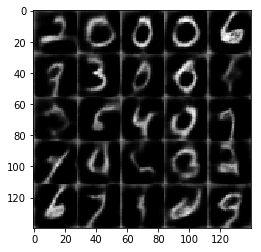

Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 2.5431... Generator Loss: 0.1282
Epoch 2/2... Discriminator Loss: 1.4910... Generator Loss: 0.3398
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 0.5316
Epoch 2/2... Discriminator Loss: 0.7125... Generator Loss: 1.6135
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.0817
Epoch 2/2... Discriminator Loss: 1.5072... Generator Loss: 0.3853
Epoch 2/2... Discriminator Loss: 0.7847... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 0.5154
Epoch 2/2... Discriminator Loss: 1.9265... Generator Loss: 0.2305


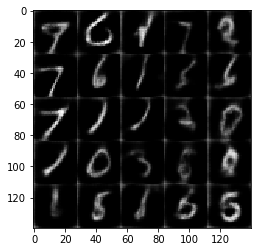

Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.5805
Epoch 2/2... Discriminator Loss: 0.6447... Generator Loss: 1.5735
Epoch 2/2... Discriminator Loss: 1.5011... Generator Loss: 0.3670
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.7447
Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 2.0840
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 0.5782


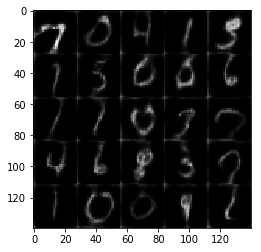

Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.5448
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 1.0453
Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 0.3551
Epoch 2/2... Discriminator Loss: 2.0616... Generator Loss: 0.2300
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 1.5903
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.6065
Epoch 2/2... Discriminator Loss: 1.9434... Generator Loss: 0.2304
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 0.6747... Generator Loss: 2.0337
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 0.7077


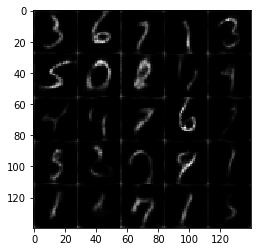

Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 1.2865
Epoch 2/2... Discriminator Loss: 0.6136... Generator Loss: 1.4822
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.5110
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.5056
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.4259
Epoch 2/2... Discriminator Loss: 1.8928... Generator Loss: 0.3290
Epoch 2/2... Discriminator Loss: 0.5725... Generator Loss: 1.6092
Epoch 2/2... Discriminator Loss: 1.5117... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 0.7364
Epoch 2/2... Discriminator Loss: 0.7422... Generator Loss: 0.9896


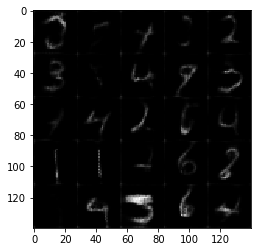

Epoch 2/2... Discriminator Loss: 0.7093... Generator Loss: 1.0652
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 1.6552
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.6241
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 0.5825
Epoch 2/2... Discriminator Loss: 1.9418... Generator Loss: 0.2617
Epoch 2/2... Discriminator Loss: 1.0676... Generator Loss: 0.6057
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 0.9096


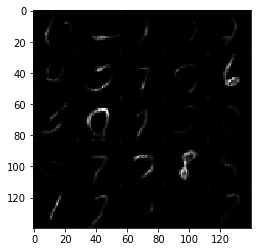

Epoch 2/2... Discriminator Loss: 1.0319... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.0469
Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.5628
Epoch 2/2... Discriminator Loss: 0.7415... Generator Loss: 0.9716
Epoch 2/2... Discriminator Loss: 0.5672... Generator Loss: 1.2176
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 2.7321
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 1.7267
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 1.3687


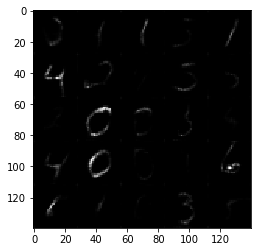

Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 1.1167
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 1.0305
Epoch 2/2... Discriminator Loss: 0.6466... Generator Loss: 1.4810
Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 1.6949
Epoch 2/2... Discriminator Loss: 1.3842... Generator Loss: 0.3693
Epoch 2/2... Discriminator Loss: 1.8984... Generator Loss: 0.2164
Epoch 2/2... Discriminator Loss: 0.5857... Generator Loss: 1.2687
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 0.4064


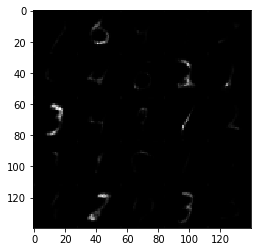

Epoch 2/2... Discriminator Loss: 0.5260... Generator Loss: 1.6592
Epoch 2/2... Discriminator Loss: 0.5084... Generator Loss: 1.6109
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 1.5483
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.4017
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 1.1107
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 0.8120
Epoch 2/2... Discriminator Loss: 0.7171... Generator Loss: 2.0286
Epoch 2/2... Discriminator Loss: 0.7430... Generator Loss: 1.2768
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 3.0183


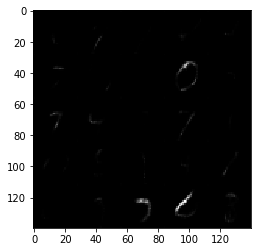

Epoch 2/2... Discriminator Loss: 1.5145... Generator Loss: 0.3476
Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 1.6255
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.7797
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 0.8821
Epoch 2/2... Discriminator Loss: 0.6895... Generator Loss: 2.3043
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 3.0443
Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 0.5855
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 2.0034... Generator Loss: 0.2395
Epoch 2/2... Discriminator Loss: 2.0676... Generator Loss: 0.1906


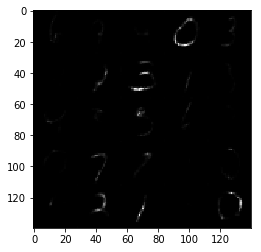

Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 1.4002
Epoch 2/2... Discriminator Loss: 0.3809... Generator Loss: 2.6185
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.7506
Epoch 2/2... Discriminator Loss: 0.6813... Generator Loss: 1.2103
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 2.0378
Epoch 2/2... Discriminator Loss: 0.4127... Generator Loss: 1.6455
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 1.0787
Epoch 2/2... Discriminator Loss: 0.7213... Generator Loss: 1.2617
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.0097


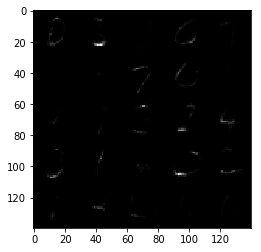

Epoch 2/2... Discriminator Loss: 1.0053... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 0.3918... Generator Loss: 1.6152
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 4.0062
Epoch 2/2... Discriminator Loss: 0.3947... Generator Loss: 1.9823
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 3.2817... Generator Loss: 6.5573
Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 2.3033
Epoch 2/2... Discriminator Loss: 2.7733... Generator Loss: 0.1042
Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 0.9433
Epoch 2/2... Discriminator Loss: 0.8154... Generator Loss: 2.1787


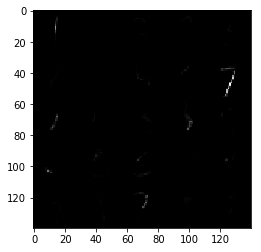

Epoch 2/2... Discriminator Loss: 0.6810... Generator Loss: 1.1893
Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 2.8609
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 0.8582
Epoch 2/2... Discriminator Loss: 0.6708... Generator Loss: 2.0207
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.9245
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 1.4667
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 0.7532
Epoch 2/2... Discriminator Loss: 0.5542... Generator Loss: 1.3426
Epoch 2/2... Discriminator Loss: 2.1431... Generator Loss: 0.2202


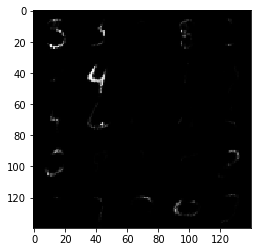

Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 2.3060
Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 1.5041
Epoch 2/2... Discriminator Loss: 2.2719... Generator Loss: 0.2170
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 1.7935
Epoch 2/2... Discriminator Loss: 0.5953... Generator Loss: 1.4078
Epoch 2/2... Discriminator Loss: 1.7070... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 1.6739... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 2.3687... Generator Loss: 0.2260
Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 1.7969
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 0.8422


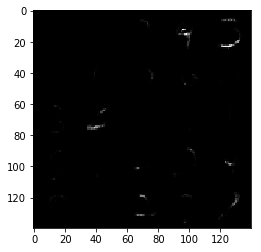

Epoch 2/2... Discriminator Loss: 0.3620... Generator Loss: 1.7617
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 1.1473
Epoch 2/2... Discriminator Loss: 0.3233... Generator Loss: 1.7416
Epoch 2/2... Discriminator Loss: 2.0362... Generator Loss: 4.1473
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 1.4551... Generator Loss: 0.4728
Epoch 2/2... Discriminator Loss: 2.1031... Generator Loss: 0.2627
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 1.4827
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.7081


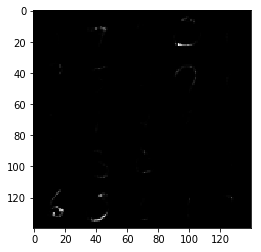

Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 0.4788
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 0.7520... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 1.9141
Epoch 2/2... Discriminator Loss: 0.6543... Generator Loss: 1.3101
Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.0248
Epoch 2/2... Discriminator Loss: 2.0711... Generator Loss: 0.2401
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 3.0019... Generator Loss: 5.6702


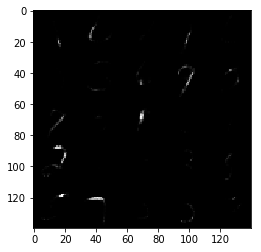

Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 1.4008
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.4273
Epoch 2/2... Discriminator Loss: 0.2883... Generator Loss: 2.8298
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 4.4321
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.4630
Epoch 2/2... Discriminator Loss: 0.3709... Generator Loss: 1.9107
Epoch 2/2... Discriminator Loss: 2.0885... Generator Loss: 4.0804


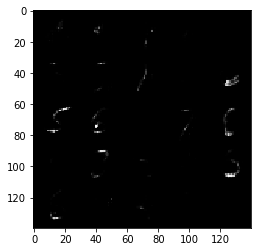

Epoch 2/2... Discriminator Loss: 0.7857... Generator Loss: 0.9063
Epoch 2/2... Discriminator Loss: 0.3972... Generator Loss: 1.7030
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 2.2013... Generator Loss: 0.2141
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 2.5198


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.